# Bessemer Hackathon Using Coiled

Hi Matt! Over the past quarter Bessemer has been working on a model to predict valuation step-ups in early stage companies. Yesterday, we had a mini hackathon where we ported a very small chunk of our model to this coiled-hosted notebook to see how Coiled and Dask work! As you can see in our MSE plot, we clearly didn't port over any hyperparameter tuning to optimize the model but hoping to do that after the holidays!  

## Pip install dependencies

In [18]:
!pip install dask
!pip install pyfiglet
!pip install coiled
!pip install modin[ray]
!pip install hvplot
!pip install dask_ml
!pip install matplotlib
!coiled login --token f5fcedf00f9377ea379aa86a6431bb78d33a451e

Credentials have been saved at /home/jovyan/.config/dask/coiled.yaml


## Import libs

In [19]:
import numpy as np
import pandas as pd
import csv
import coiled
import modin.pandas as modin_pd
from pyfiglet import Figlet
from datetime import datetime
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask.dataframe as dd
from sklearn import preprocessing
from joblib import Parallel, parallel_backend
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

## Crucial note

In [20]:
f = Figlet(font='slant')
print(f.renderText('BVP LOVES COILED'))

    ____ _    ______     __    ____ _    _____________
   / __ ) |  / / __ \   / /   / __ \ |  / / ____/ ___/
  / __  | | / / /_/ /  / /   / / / / | / / __/  \__ \ 
 / /_/ /| |/ / ____/  / /___/ /_/ /| |/ / /___ ___/ / 
/_____/ |___/_/      /_____/\____/ |___/_____//____/  
                                                      
   __________  ______    __________ 
  / ____/ __ \/  _/ /   / ____/ __ \
 / /   / / / // // /   / __/ / / / /
/ /___/ /_/ // // /___/ /___/ /_/ / 
\____/\____/___/_____/_____/_____/  
                                    



## Connect to Coiled

In [5]:
cluster = coiled.Cluster(
    n_workers=5, 
    software="examples/optuna-xgboost"
)
client = Client(cluster)
client.wait_for_workers(5)

print('Dashboard:', client.dashboard_link)

Creating Cluster. This takes about a minute ...Checking environment images
Valid environment image found
Dashboard: https://cloud.coiled.io/dashboard/3403/status


## Time series comparison between Pandas, Ray and Coiled

In [21]:
start_time = datetime.now()
pandas_df = pd.read_csv('https://www.dropbox.com/s/hp5dlbua9v6rwps/OUT_companies.csv?dl=1', encoding = 'ISO-8859-1')
time_elapsed = datetime.now() - start_time 
print ('[PANDAS] Time to process (hh:mm:ss:ms) {}'.format(time_elapsed))

start_time = datetime.now()
modin_df = modin_pd.read_csv('https://www.dropbox.com/s/hp5dlbua9v6rwps/OUT_companies.csv?dl=1', encoding = 'ISO-8859-1')
time_elapsed = datetime.now() - start_time 
print ('[RAY] Time to process (hh:mm:ss:ms) {}'.format(time_elapsed))

start_time = datetime.now()
coiled_df = dd.read_csv('https://www.dropbox.com/s/hp5dlbua9v6rwps/OUT_companies.csv?dl=1', encoding = 'ISO-8859-1')
time_elapsed = datetime.now() - start_time 
print ('[COILED] Time to process (hh:mm:ss:ms) {}'.format(time_elapsed))

[PANDAS] Time to process (hh:mm:ss:ms) 0:00:08.747382
[RAY] Time to process (hh:mm:ss:ms) 0:00:09.403507
[COILED] Time to process (hh:mm:ss:ms) 0:00:03.582213


## Process data in the cloud

In [22]:
import dask.dataframe as dd
from dask.distributed import wait
df = dd.read_csv(
    "s3://coiled2020/OUT_companies.csv",
    dtype={'conversion_ratio_x': 'object',
       'conversion_ratio_y': 'object',
       'customers': 'object',
       'deal_type_3': 'object',
       'debt_type_2': 'object',
       'debt_type_3': 'object',
       'market': 'object',
       'morningstar_codes': 'object',
       'naics_codes': 'object',
       'sic_codes': 'object',
       'zip': 'object',
       'employee_count': 'float64',
       'deal_size': 'float64',
       'stock_series': 'string',
       'post_valuation': 'float64',
       'year_founded': 'string',
    },
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()
wait(df)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 4)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 1)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 6)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 2)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 7)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 3)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 8)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 10)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623ed5f39f19bba', 0)>, <Future: finished, type: pandas.DataFrame, key: ('read-csv-a49ec3b864ca4b686623e

## Basic cleaning

In [23]:
print ('companies before cleaning', len(df))
unique_companies = df.company_id.unique()
print('companies after cleaning', len(unique_companies))
display(df['post_valuation'].head())

companies before cleaning 109626
companies after cleaning 22067


0         NaN
1    60.00000
2    60.00000
3    60.00000
4    63.74999
Name: post_valuation, dtype: float64

In [24]:
missing_values = df.isnull().sum()
with ProgressBar():
    percent_missing = ((missing_values / df.index.size) * 100).compute()
percent_missing

company_id                    0.000000
company_name_x                3.773740
familiar_name                82.116469
previous_name                68.718187
exchange                     94.060716
                               ...    
liquidation                  12.135807
liquidation_pref_mutliple    19.447029
conversion_price             11.898637
percent_owned                12.087461
last_updated_y_y             11.334902
Length: 166, dtype: float64

In [25]:
df = df.dropna(subset=['post_valuation','year_founded'])

## Plot histrogram of series

<AxesSubplot:>

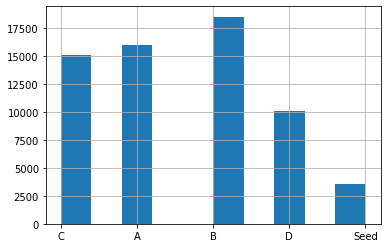

In [26]:
df.loc[df.stock_series.isin(["A", "B", "C", "D", "Seed"])].compute()['stock_series'].hist()   

## Train random forest model

In [27]:
computed_df = df.compute()
computed_df = computed_df.loc[:,['year_founded','total_raised_to_date','state','zip','ceo_first_name','post_valuation']]
computed_df = computed_df.dropna(axis=0)
X_train = computed_df.loc[:,['year_founded','total_raised_to_date','state','zip','ceo_first_name']]
y = computed_df.post_valuation.astype('float')
le = preprocessing.LabelEncoder()
le.fit(X_train['ceo_first_name'].astype(str))
X_train.loc[:,'ceo_first_name'] = le.transform(X_train['ceo_first_name'].astype(str))
le.fit(X_train['zip'])
X_train.loc[:,'zip'] = le.transform(X_train['zip'])

## Calculate error 

In [28]:
n_estimators = [10,50,100,200,300]
errors = []
with parallel_backend('dask'):
    for i in n_estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train,y)
        y_pred = rfr.predict(X_train)
        print(f'RMSE Error {i} : {metrics.mean_absolute_error(y, y_pred)}')
        errors.append(metrics.mean_absolute_error(y, y_pred))

RMSE Error 10 : 84.24259156670361
RMSE Error 50 : 84.06805750937436
RMSE Error 100 : 84.03621233908649
RMSE Error 200 : 84.03902830821886
RMSE Error 300 : 83.99207972477093


## Plot error

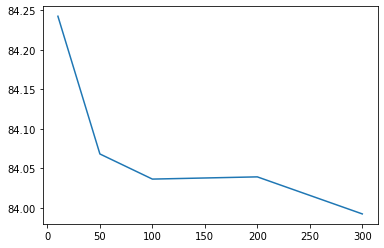

In [29]:
plt.plot(n_estimators,errors)